In [1]:
import os
import sys
import re
import gc
import time
import datetime
import pickle
import numpy as np
import pandas as pd

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Data

In [3]:
train = pd.read_csv('./sales_train.csv')
items = pd.read_csv('./items.csv')
# Drop name to save space
items = items.drop('item_name', axis=1)
# Set index to ID to avoid droping it later
test  = pd.read_csv('./test.csv').set_index('ID')
# Add date_block_num = 34
test['date_block_num'] = 34
#shops = pd.read_csv('../input/shops.csv')
#categories = pd.read_csv('../input/item_categories.csv')

### Compress data size

In [4]:
# Get the ranges of each feature to select the most appropriate data size
print ('train:')
for f in train.columns.values:
    print ('%s: %s ~ %s' %(f, train[f].min(), train[f].max()))
print ('items:')
for f in items.columns.values:
    print ('%s: %s ~ %s' %(f, items[f].min(), items[f].max()))
print ('test:')
for f in test.columns.values:
    print ('%s: %s ~ %s' %(f, test[f].min(), test[f].max()))

train:
date: 01.01.2013 ~ 31.12.2014
date_block_num: 0 ~ 33
shop_id: 0 ~ 59
item_id: 0 ~ 22169
item_price: -1.0 ~ 307980.0
item_cnt_day: -22.0 ~ 2169.0
items:
item_id: 0 ~ 22169
item_category_id: 0 ~ 83
test:
shop_id: 2 ~ 59
item_id: 30 ~ 22167
date_block_num: 34 ~ 34


### Final data ranges for figuring out the best data size per column
shop_id: 0 ~ 59<br>
item_id: 0 ~ 22169<br>
date_block_num: 0 ~ 33<br>
item_cnt_day: 0 ~ 1644<br>
item_price: 0.0 ~ 50999.0<br>
item_category_id: 0 ~ 83<br>
<br>
item_id_avg_item_price: 0.1 ~ 50999.0<br>
item_id_sum_item_cnt_day: 0.0 ~ 12560.0<br>
item_id_avg_item_cnt_day: 0 ~ 86<br>
shop_id_avg_item_price: 77.0 ~ 1903.0<br>
shop_id_sum_item_cnt_day: 0 ~ 16338<br>
shop_id_avg_item_cnt_day: 0.0 ~ 4.883<br>
item_category_id_avg_item_price: 4.867 ~ 30200.0<br>
item_category_id_sum_item_cnt_day: 0 ~ 36311<br>
item_category_id_avg_item_cnt_day: 0 ~ 50<br>
<br>
item_id_sum_item_cnt_day_lag_1: 0.0 ~ 12560.0<br>
item_id_avg_item_cnt_day_lag_1: 0.0 ~ 86.0<br>
shop_id_avg_item_price_lag_1: 77.0 ~ 1903.0<br>
shop_id_sum_item_cnt_day_lag_1: 2.0 ~ 16338.0<br>
shop_id_avg_item_cnt_day_lag_1: 1.0 ~ 4.883<br>
item_category_id_avg_item_price_lag_1: 4.867 ~ 29220.0<br>
item_category_id_sum_item_cnt_day_lag_1: 1.0 ~ 36311.0<br>
item_category_id_avg_item_cnt_day_lag_1: 1.0 ~ 22.0<br>
item_cnt_day_lag_1: 0.0 ~ 1305.0<br>

In [5]:
def compress_columns(df,columns,keyword,search_type,datatype):
    if search_type=='in':
        valid_features = [x for x in columns if keyword in x]
    elif search_type=='start':
        valid_features = [x for x in columns if x.startswith(keyword)]
    if len(valid_features):
        for f in valid_features:
            df[f] = df[f].round().astype(datatype)
    return df

def data_compression(df):
    features = df.columns.values
    # Original features
    if 'date_block_num' in features:
        df['date_block_num'] = df['date_block_num'].astype(np.int8)
    if 'shop_id' in features:
        df['shop_id'] = df['shop_id'].astype(np.int8)
    if 'item_category_id' in features:
        df['item_category_id'] = df['item_category_id'].astype(np.int8)
    if 'item_id' in features:
        df['item_id'] = df['item_id'].astype(np.int16)
    if 'item_price' in features:
        df['item_price'] = df['item_price'].astype(np.float32)
    if 'item_id_avg_item_price' in features:
        df['item_id_avg_item_price'] = df['item_id_avg_item_price'].astype(np.float32)
        
    # Mean encoded features & lag features
    df = compress_columns(df,features,'item_id_sum_item_cnt_day','in',np.int16)
    df = compress_columns(df,features,'item_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'shop_id_avg_item_price','in',np.float16)
    df = compress_columns(df,features,'shop_id_sum_item_cnt_day','in',np.int16)
    df = compress_columns(df,features,'shop_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'item_category_id_avg_item_price','in',np.float16)
    df = compress_columns(df,features,'item_category_id_sum_item_cnt_day','in',np.int32)
    df = compress_columns(df,features,'item_category_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'item_cnt_day','start',np.int16)

    return df

In [6]:
# Compress features according to range
train = data_compression(train)
items = data_compression(items)
test = data_compression(test)

In [7]:
# Include Category id
train = pd.merge(train,items,on='item_id',how='left')
test = pd.merge(test,items, on='item_id', how='left')

### Created a dataframe of all Date_block_num, Store and Item combinations:
So in case in the months some shops did not have the sale record of some item, it can be set to 0.

In [8]:
# Create a grid with columns
index_cols = ['shop_id','item_id','date_block_num']

# For every month we create a grid for all shops/items pair
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num']==block_num,'shop_id'].unique()
    cur_items = train.loc[train['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_cols,dtype=np.int32)
grid = data_compression(grid)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [9]:
grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913850 entries, 0 to 10913849
Data columns (total 3 columns):
shop_id           int8
item_id           int16
date_block_num    int8
dtypes: int16(1), int8(2)
memory usage: 41.6 MB


### Check for outliers

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
date                object
date_block_num      int8
shop_id             int8
item_id             int16
item_price          float32
item_cnt_day        int16
item_category_id    int8
dtypes: float32(1), int16(2), int8(3), object(1)
memory usage: 75.6+ MB


Only item_price & item_cnt_day need to be checked, the other columns are meta features.

**Check outliers removal**

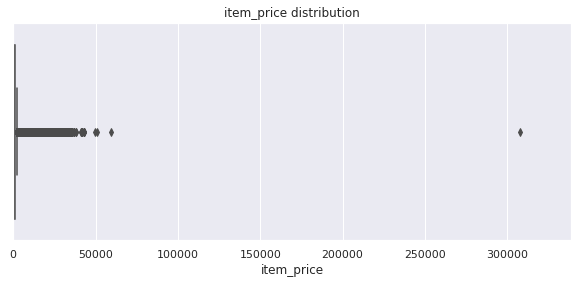

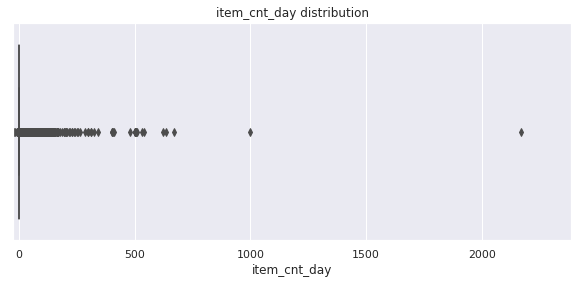

In [11]:
def box_plot(df,f):
    plt.figure(figsize=(10,4))
    plt.title(f+' distribution')
    x_min = int(df[f].min() - (abs(df[f].min())*0.1))
    x_max = int(df[f].max() + (abs(df[f].max())*0.1))
    if x_min==0:
        x_min = -1
    if x_max==0:
        x_max = 1
    plt.xlim(x_min,x_max)
    sns.boxplot(x=df[f])

# plot distribution of the 2 columns
plot_features = ['item_price','item_cnt_day']
for f in plot_features:
    box_plot(train,f)

In [12]:
# Getting rid of the outliers & negative values
train = train[(train['item_price']<100000) & (train['item_price']>=0)]
train = train[(train['item_cnt_day']<1000) & (train['item_cnt_day']>=0)]

**Distribution after outlier removal**

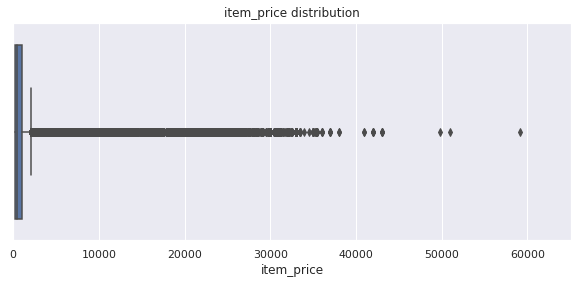

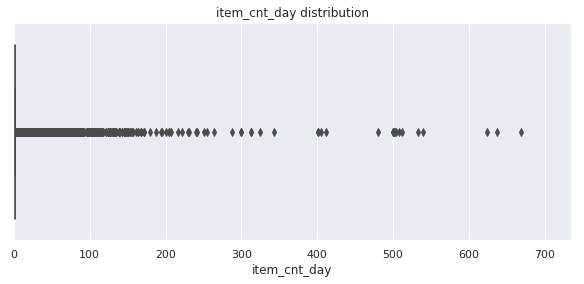

In [13]:
# plot distribution of the 2 columns
plot_features = ['item_price','item_cnt_day']
for f in plot_features:
    box_plot(train,f)

### Merge duplicated shops
The duplicated shops can be found by inspecting the shop names in shops list.

In [14]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Create Mean Encodings
These below lines add the following 9 features:<br>
<br>
All of which are per month.<br>
‘item_id_avg_item_price’: Mean item price per item_id<br>
‘item_id_sum_item_cnt_day’: Total item count per item_id<br>
‘item_id_avg_item_cnt_day’: Mean item count per item_id<br>
‘shop_id_avg_item_price’: Mean item price per shop<br>
‘shop_id_sum_item_cnt_day’: Total item count per shop<br>
‘shop_id_avg_item_cnt_day’: Mean item count per shop<br>
‘item_category_id_avg_item_price’: Mean item price per category<br>
‘item_category_id_sum_item_cnt_day’: Total item count per category<br>
‘item_category_id_avg_item_cnt_day’: Mean item count per category<br>

In [15]:
# Group items per month, per shop, per item, sum the sales of the item, mean the price
# There is a big difference between np.mean and pandas mean
train_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
train_m = pd.merge(grid,train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
train_m = pd.merge(train_m,items,on='item_id',how='left')
train_m = data_compression(train_m)

In [16]:
# Making the mean features
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = train.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        train_m = pd.merge(train_m, mean_df, on=['date_block_num',type_id], how='left')
        del mean_df
        gc.collect()

In [17]:
# No more use of train, clear some space
del train
gc.collect()

14

### Fill NaNs
Because NaN cannot be converted to int, therefore NaN has to be filled.<br>
Because there are many items which did not sale a single piece per store per month, there are many Nans.<br> 
The Nans in item count means 0 sold, therefore will be filled with 0.<br>
The Nans in item price however means since there is no sale record of the item, the price is missin, therefore will be filled with median / mean price of the item.

In [18]:
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

# Compress data
train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Columns: 15 entries, shop_id to item_category_id_avg_item_cnt_day
dtypes: float16(5), float32(2), int16(4), int32(1), int8(3)
memory usage: 426.7 MB


### Create Lag Features
Next we create lag features with diferent lag periods on the following features:<br>
<br>
‘item_id_avg_item_price’,<br>
‘item_id_sum_item_cnt_day’<br>
‘item_id_avg_item_cnt_day’<br>
‘shop_id_avg_item_price’<br>
‘shop_id_sum_item_cnt_day’<br>
‘shop_id_avg_item_cnt_day’<br>
‘item_category_id_avg_item_price’<br>
‘item_category_id_sum_item_cnt_day’<br>
‘item_category_id_avg_item_cnt_day’<br>
‘item_cnt_day’

In [19]:
# Check the positions of the base lag features
train_m.columns.values[6:]

array(['item_id_avg_item_price', 'item_id_sum_item_cnt_day',
       'item_id_avg_item_cnt_day', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'], dtype=object)

In [20]:
# Get all the monthly features, which means the Mean Encoded fatures are all monthly based
lag_features = list(train_m.columns[6:])+['item_cnt_day']
# The selected months 
lags = [1,2,3,6]

for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    train_m = pd.merge(train_m,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [21]:
# Fill NaNs
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Columns: 55 entries, shop_id to item_cnt_day_lag_6
dtypes: float16(25), float32(6), int16(16), int32(5), int8(3)
memory usage: 1.4 GB


### Clipping train data to make it similar to test set
In the evaluation data description on the competition page, it is said to clip target values to [0,20], because the test set ranges are in between these numbers.<br>
In the next few lines I clipped the days to range[0,30].<br>
You might ask me why 30. An intuitive answer is if I had clipped to range [0,20] there would be very few tree nodes that could give 20 as an answer.<br>
While if I increase it to 40 having a 20 becomes much more easier.<br>
Please note that We will clip our predictions in the [0,20] range in the end.

In [22]:
# Set the maximum clip value
max_clip = 30
train_m['item_cnt_day'] = train_m['item_cnt_day'].clip(0,max_clip).astype(np.float16)

### Prepare test set

In [23]:
# Add lag variables
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    test = pd.merge(test,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [24]:
# Fill NaNs
for f in test.columns:
    if 'item_cnt' in f:
        test[f] = test[f].fillna(0)
    elif 'item_price' in f:
        test[f] = test[f].fillna(test[f].median())

test = data_compression(test)

### Drop all columns which are not lag features
Exceptions:<br> 
shop_id, item_id: not time dependent<br> 
date_block_num: the indicator of time<br> 
item_cnt_Day: the target

In [25]:
cols_to_drop = lag_features[:-1] + ['item_price']
print ('Columns to drop')
print (cols_to_drop)

Columns to drop
['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [26]:
train_cols = train_m.columns.values
test_cols = test.columns.values
for c in cols_to_drop:
    if c in train_cols:
        train_m = train_m.drop(c,axis=1)
    if c in test_cols:
        test = test.drop(c,axis=1)

### Create New Features

In [27]:
# Month number
train_m['month'] = train_m['date_block_num']%12
train_m['month'] = train_m['month'].astype(np.int8)
# Number of days in a month, no leap years here
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_m['days'] = train_m['month'].map(days).astype(np.int8)

test['month'] = 11
test['month'] = test['month'].astype(np.int8)
test['days'] = 30
test['days'] = test['days'].astype(np.int8)

### Check if test lag variables are correct

In [28]:
# Assert all the columns are the same except target column
set(train_m.columns.values) ^ set(test.columns.values)

{'item_cnt_day'}

In [29]:
train_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,59,22154,0,1.00,37,299.00,0,0.00,891.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,883.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,878.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,859.00,0,0.00,376.00,0,0.00,0,0,31
1,59,2552,0,0.00,58,299.00,0,0.00,891.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,883.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,878.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,859.00,0,0.00,376.00,0,0.00,0,0,31
2,59,2554,0,0.00,58,299.00,0,0.00,891.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,883.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,878.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,859.00,0,0.00,376.00,0,0.00,0,0,31
3,59,2555,0,0.00,56,299.00,0,0.00,891.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,883.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,878.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,859.00,0,0.00,376.00,0,0.00,0,0,31
4,59,2564,0,0.00,59,299.00,0,0.00,891.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,883.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,878.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,859.00,0,0.00,376.00,0,0.00,0,0,31


In [30]:
test.head()

,shop_id,item_id,date_block_num,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,5,5037,34,19,1499.00,25,1.00,1028.00,1054,1.00,1680.00,2450,1.00,0,936.68,111,1.00,1037.00,1098,1.00,1360.00,3998,1.00,1,894.59,119,1.00,911.00,1297,1.00,1140.00,4674,1.00,3,1542.87,87,1.00,959.00,1013,1.00,1418.00,3407,1.00,1,11,30
1,5,5320,34,55,449.00,0,0.00,1255.00,0,0.00,510.00,0,0.00,0,432.00,0,0.00,1204.00,0,0.00,511.00,0,0.00,0,435.33,0,0.00,980.00,0,0.00,488.00,0,0.00,0,437.75,0,0.00,1100.00,0,0.00,559.00,0,0.00,0,11,30
2,5,5233,34,19,1199.00,42,1.00,1028.00,1054,1.00,1680.00,2450,1.00,1,711.71,80,1.00,1037.00,1098,1.00,1360.00,3998,1.00,3,712.15,150,1.00,911.00,1297,1.00,1140.00,4674,1.00,1,790.03,71,1.00,959.00,1013,1.00,1418.00,3407,1.00,3,11,30
3,5,5232,34,23,1190.14,29,1.00,1028.00,1054,1.00,1796.00,2213,1.00,0,703.49,48,1.00,1037.00,1098,1.00,1269.00,3610,1.00,0,642.47,65,1.00,911.00,1297,1.00,1164.00,3666,1.00,1,437.75,0,0.00,1100.00,0,0.00,559.00,0,0.00,0,11,30
4,5,5268,34,20,449.00,0,0.00,1255.00,0,0.00,510.00,0,0.00,0,432.00,0,0.00,1204.00,0,0.00,511.00,0,0.00,0,435.33,0,0.00,980.00,0,0.00,488.00,0,0.00,0,437.75,0,0.00,1100.00,0,0.00,559.00,0,0.00,0,11,30


It seems that the order of the columns are the same for train & test.<br>
(Except for the target column 'item_cnt_day')

In [31]:
test[['shop_id','item_id']+['item_cnt_day_lag_'+str(x) for x in [1,2,3]]].head()

,shop_id,item_id,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,5,5037,0,1,3
1,5,5320,0,0,0
2,5,5233,1,3,1
3,5,5232,0,0,1
4,5,5268,0,0,0


In [32]:
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 33]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 32]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 31]['item_cnt_day'])

10849431   0.00
Name: item_cnt_day, dtype: float16
10605772   1.00
Name: item_cnt_day, dtype: float16
10396094   3.00
Name: item_cnt_day, dtype: float16


the lagged value for (5	5037) actually correspond, looks like we dont have bugs!

### Take the recent bit of data
Data too far in the past are considered to be less relevant

In [33]:
train_m = train_m[train_m['date_block_num']>12]

### Split into train & validation
Validation: The last month 'date_block_num'==33
Train: Everything else

In [34]:
train_set = train_m[train_m['date_block_num']<33]
val_set = train_m[train_m['date_block_num']==33]

In [35]:
print (train_set.shape)
print (val_set.shape)
print (test.shape)

(5839576, 47)
(238172, 47)
(214200, 46)


### Export the preprocessed data

In [36]:
# Save data
train_set.to_pickle('train.pkl')
val_set.to_pickle('val.pkl')
test.to_pickle('test.pkl')

In [37]:
del train_m
gc.collect()

21

### Modelling

In [38]:
train_x = train_set.drop(['item_cnt_day'],axis=1)
train_y = train_set['item_cnt_day']
val_x = val_set.drop(['item_cnt_day'],axis=1)
val_y = val_set['item_cnt_day']

In [39]:
features = list(train_x.columns.values)

In [40]:
print (train_x.shape)
print (train_y.shape)
print (val_x.shape)
print (val_y.shape)
print (test.shape)

(5839576, 46)
(5839576,)
(238172, 46)
(238172,)
(214200, 46)


In [41]:
del train_set
del val_set
gc.collect()

0

In [42]:
# For plotting feature importance
def plot_feature_importances(importances,indices,features,title):
    plt.figure(figsize=(9,16))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()   

### Linear Regression

In [43]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

In [44]:
gc.collect()
ts = time.time()
# Training
lr = linear_model.LinearRegression()
lr.fit(train_x,train_y)
print ('Training time: %s' %(time.time() - ts))

Training time: 15.610323667526245


### Predictions

In [45]:
# Here we once again clip the output to 0~20
train_pred1 = lr.predict(train_x).clip(0, 20)
val_pred1 = lr.predict(val_x).clip(0, 20)
test_pred1 = lr.predict(test).clip(0, 20)

# Get rmse scores
train_rmse = np.sqrt(mean_squared_error(train_y, train_pred1))
print("Train RMSE: %f" % (train_rmse))
val_rmse = np.sqrt(mean_squared_error(val_y, val_pred1))
print("Val RMSE: %f" % (val_rmse))

#sub_df1 = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred1})
#sub_df1.to_csv('lr_submission.csv',index=False)

# Save predictions for emsemble
pickle.dump(train_pred1,open('lr_train.pickle','wb'))
pickle.dump(val_pred1,open('lr_val.pickle','wb'))
pickle.dump(test_pred1,open('lr_test.pickle','wb'))

Train RMSE: 1.150121
Val RMSE: 1.168151


### xgboost

In [47]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

In [48]:
gc.collect()
ts = time.time()
xgbtrain = xgb.DMatrix(train_x.values, train_y.values)

param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'verbosity':2,
         'eval_metric':'rmse'} # random parameters

bst = xgb.train(param, xgbtrain)
print ('Training time: %s' %(time.time() - ts))

[16:37:22] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:38:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1602 extra nodes, 0 pruned nodes, max_depth=10
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1632 extra nodes, 0 pruned nodes, max_depth=10
[16:40:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1646 extra nodes, 0 pruned nodes, max_depth=10
[16:41:16] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1564 extra nodes, 0 pruned nodes, max_depth=10
[16:42:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1648 extra nodes, 0 pruned nodes, max_depth=10
[16:43:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1650 extra nodes, 0 pruned nodes, max_dep

In [49]:
# Here we once again clip the output to 0~20
train_pred2 = bst.predict(xgb.DMatrix(train_x.values)).clip(0, 20)
val_pred2 = bst.predict(xgb.DMatrix(val_x.values)).clip(0, 20)
test_pred2 = bst.predict(xgb.DMatrix(test.values)).clip(0, 20)

# Get rmse scores
train_rmse = np.sqrt(mean_squared_error(train_y, train_pred2))
print("Train RMSE: %f" % (train_rmse))
val_rmse = np.sqrt(mean_squared_error(val_y, val_pred2))
print("Val RMSE: %f" % (val_rmse))

#sub_df2 = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred2 })
#sub_df2.to_csv('xgb_submission.csv',index=False)

# Save predictions for emsemble
pickle.dump(train_pred2,open('xgb_train.pickle','wb'))
pickle.dump(val_pred2,open('xgb_val.pickle','wb'))
pickle.dump(test_pred2,open('xgb_test.pickle','wb'))

Train RMSE: 0.903894
Val RMSE: 1.069696


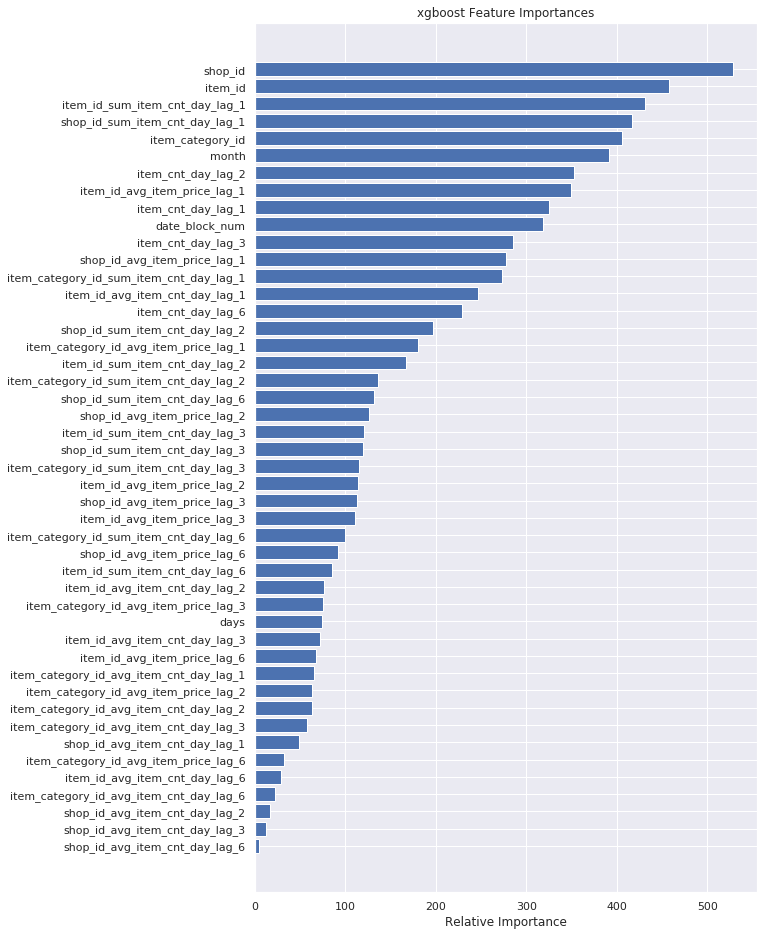

In [50]:
# feature importance
import operator
importance = sorted(bst.get_score().items(), key=operator.itemgetter(1))
importance_v = np.asarray([x[1] for x in importance],dtype=np.int16)
indices = np.asarray([int(x[0].replace('f','')) for x in importance],dtype=np.int8)
title = 'xgboost Feature Importances'

plt.figure(figsize=(9,16))
plt.title(title)
plt.barh(range(len(indices)), importance_v, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()   

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
gc.collect()
ts = time.time()
rf = RandomForestRegressor(
 bootstrap=True,
 max_depth=100,
 max_features= 3,
 min_samples_leaf=5,
 min_samples_split=12,
 n_estimators=100,
 random_state=42,
 verbose=1,
 n_jobs=-1
)
rf.fit(train_x.values,train_y.values)
print ('Training time: %s' %(time.time() - ts))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


Training time: 896.9886200428009


In [53]:
# Here we once again clip the output to 0~20
train_pred3 = rf.predict(train_x).clip(0, 20)
val_pred3 = rf.predict(val_x).clip(0, 20)
test_pred3 = rf.predict(test).clip(0, 20)

# Get rmse scores
train_rmse = np.sqrt(mean_squared_error(train_y, train_pred3))
print("Train RMSE: %f" % (train_rmse))
val_rmse = np.sqrt(mean_squared_error(val_y, val_pred3))
print("Val RMSE: %f" % (val_rmse))

#sub_df3 = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred3})
#sub_df3.to_csv('rf_submission.csv',index=False)

# Save predictions for emsemble
pickle.dump(train_pred3,open('rf_train.pickle','wb'))
pickle.dump(val_pred3,open('rf_val.pickle','wb'))
pickle.dump(test_pred3,open('rf_test.pickle','wb'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


Train RMSE: 0.747731
Val RMSE: 1.052844


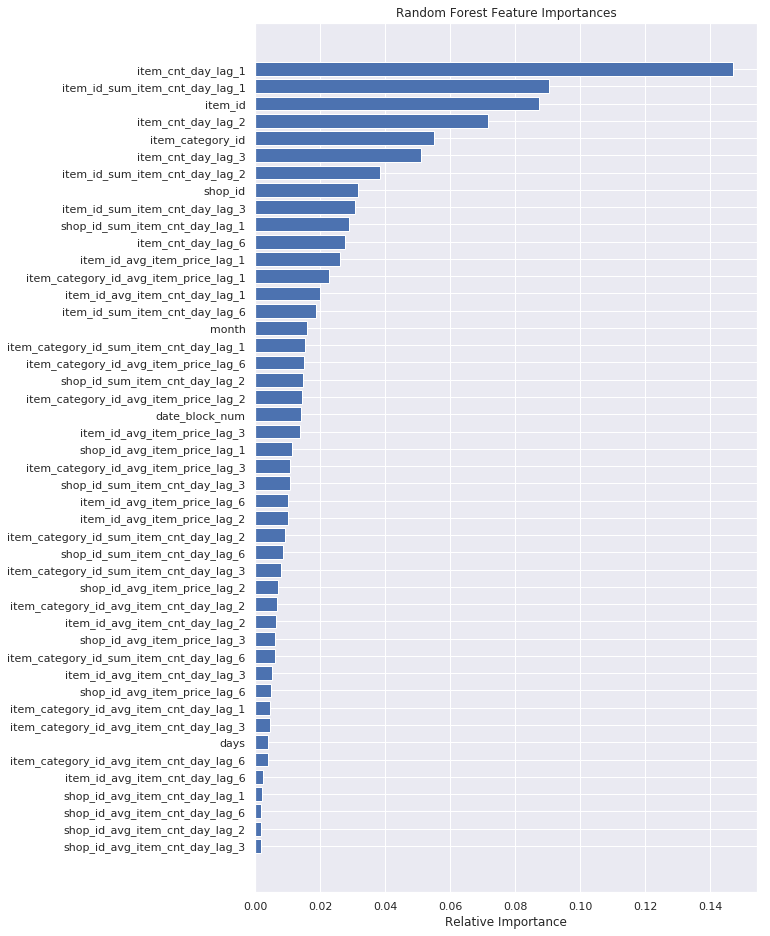

In [54]:
importances = rf.feature_importances_
indices = np.argsort(importances)
title = 'Random Forest Feature Importances'
plot_feature_importances(importances,indices,features,title)

## Stacking

In [55]:
train_stack = pd.DataFrame({'lr':train_pred1,'xgboost':train_pred2,'rf':train_pred3})
val_stack = pd.DataFrame({'lr':val_pred1,'xgboost':val_pred2,'rf':val_pred3})
test_stack = pd.DataFrame({'lr':test_pred1,'xgboost':test_pred2,'rf':test_pred3})

In [56]:
gc.collect()
ts = time.time()
# Training
stack_lr = linear_model.LinearRegression()
stack_lr.fit(train_stack,train_y)
print ('Training time: %s' %(time.time() - ts))

Training time: 0.9946889877319336


### Predictions

In [57]:
# Here we once again clip the output to 0~20
train_pred4 = stack_lr.predict(train_stack).clip(0, 20)
val_pred4 = stack_lr.predict(val_stack).clip(0, 20)
test_pred4 = stack_lr.predict(test_stack).clip(0, 20)

# Get rmse scores
train_rmse = np.sqrt(mean_squared_error(train_y, train_pred4))
print("Train RMSE: %f" % (train_rmse))
val_rmse = np.sqrt(mean_squared_error(val_y, val_pred4))
print("Val RMSE: %f" % (val_rmse))

sub_df4 = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred4})
sub_df4.to_csv('stack_submission.csv',index=False)

# Save predictions for emsemble
pickle.dump(train_pred4,open('stack_train.pickle','wb'))
pickle.dump(val_pred4,open('stack_val.pickle','wb'))
pickle.dump(test_pred4,open('stack_test.pickle','wb'))

Train RMSE: 0.666620
Val RMSE: 1.085376
